# Topic Modeling: Latent Dirichlet Allocation (LDA)

One of the widely used algorithms for topic modeling is Latent Dirichlet Allocation (LDA). Latent Dirichlet Allocation (LDA) is a statistical model that is used to discover the underlying topics in a collection of documents. It is a generative model that assumes that each document is a mixture of a fixed number of topics, and each topic is a mixture of a fixed number of words.

In LDA, each document is represented as a distribution over the set of topics, and each topic is represented as a distribution over the vocabulary of words. Given a set of documents, LDA estimates the topic distributions for each document and the word distributions for each topic.

LDA is used in a wide range of applications, including information retrieval, document classification, and topic modeling. It is a popular technique for discovering the underlying themes in a large corpus of text data and has been widely used in natural language processing and text mining.

In [1]:
# Load necessary packages
import re
import gensim
import numpy as np
import pandas as pd
import swifter
import pyLDAvis
import pyLDAvis.gensim_models

import plotly.express as px
import plotly.io as pio
svg_renderer = pio.renderers["svg"]
svg_renderer.width = 900
svg_renderer.height = 500
pio.renderers.default = "svg"
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud

from tqdm import tqdm

# pyLDAvis.enable_notebook()
tqdm.pandas()

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [2]:
# Load the preprocessed data
df = pd.read_hdf('./../../code/data/starbucks/data.h5', key='preprocessed_starbucks')

In [3]:
# Confirm the shape
df.shape

(2770, 29)

To improve the results, words coming together for large number of documents can be clubbed and then fed to the model. For the analysis, bigrams and trigrams will be used.

**Bigrams**

A bigram is a sequence of two adjacent words in a string of text. In natural language processing, bigrams are often used as a basic unit for measuring the similarity of two texts or for identifying the key topics in a document.

For example, consider the following sentence: "I went to the store to buy some milk."

The bigrams in this sentence would be: "I went", "went to", "to the", "the store", "store to", "to buy", "buy some", "some milk".

Bigrams can be useful for identifying common patterns or trends in a text. For example, if we counted the number of times each bigram occurred in a large collection of texts, we might find that certain bigrams are much more common than others, which could help us identify the most important topics or themes in the texts. Bigrams can also be used as features in machine learning models for tasks such as text classification or sentiment analysis.

**Trigrams**

Trigrams are groups of three consecutive characters or words in a given text. They are commonly used in natural language processing tasks, such as language modeling, machine translation, and spelling correction, as a way of capturing the context and relationships between words in a language.

For example, in the sentence "The cat sat on the mat," the trigrams would be "The cat," "cat sat," "sat on," "on the," and "the mat." Trigrams can provide valuable information about the likelihood of certain words or phrases appearing together, which can be useful for tasks such as language generation or prediction.

Trigrams can be computed from a given text by splitting the text into a list of three-word chunks, or by generating a list of all possible three-word combinations. They can also be computed from a list of words, by generating all possible combinations of three consecutive words in the list.

In [4]:
# Create Bigrams
def sentence_to_words(sentences):
    """Function to convert sentences to words"""
    return (gensim.utils.simple_preprocess(str(sentence), deacc=True) for sentence in sentences)

data = df['preprocessed_tweet'].values.tolist()
data_words = list(sentence_to_words(data))

bigram = gensim.models.phrases.Phrases(data_words, min_count=5, threshold=10, connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)
trigram = gensim.models.Phrases(bigram[data_words], threshold=10, connector_words=gensim.models.phrases.ENGLISH_CONNECTOR_WORDS)

bigram_model = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

df.loc[:, 'sep_words'] = df['preprocessed_tweet'].swifter.apply(lambda x: list(sentence_to_words([x]))[0])
df['bigram'] = df['sep_words'].swifter.apply(lambda x: bigram_model[x])
df['trigram'] = df['bigram'].swifter.apply(lambda x: trigram_mod[x])

Pandas Apply:   0%|          | 0/2770 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2770 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/2770 [00:00<?, ?it/s]

In [5]:
# Copy the data to another dataframe
main_df = df.copy()

## LDA with bag-of-words

As such words can not be interpreted by the machine. Hence, it is necessary to convert words into appropriate numbers. One of the simplest ways to do such a conversion is by using the bag-of-words model.

The bag-of-words model is a simple and effective representation for text data. It is a way of representing text data as numerical feature vectors. The bag-of-words model represents each document as a fixed-length vector, where each dimension of the vector represents a particular word in the vocabulary.

In the bag-of-words model, the order of the words in the document is not important. Instead, the model only looks at the presence or absence of each word in the vocabulary. If a word is present in the document, the corresponding dimension in the feature vector is set to a non-zero value, such as 1. If a word is not present in the document, the corresponding dimension is set to zero.

The bag-of-words model is a simple and effective way to represent text data for many natural language processing tasks, such as text classification, information retrieval, and language modeling. It is also a good starting point for more advanced models that take into account the order of the words in a document, such as n-gram models or recurrent neural networks.

In [6]:
# Create the dictionary of words for LDA
id2word = gensim.corpora.Dictionary(df['trigram'].values.tolist())

In [7]:
# Convert text to numbers using bag-of-words model
bow_corpus = [id2word.doc2bow(text) for text in df['trigram'].values.tolist()]

For the current data, the number of topics is unknown. Hence, it is necessary to use coherence metric to find the optimum number of topics in the data set.

Coherence is a measure of how interpretable or meaningful the topics generated by a topic model are. In Latent Dirichlet Allocation (LDA), coherence measures the degree to which the words in a topic tend to occur together in the same documents. A topic with high coherence is one in which the words are more likely to appear together in the same documents and form a coherent concept or theme.

There are several methods for calculating coherence in LDA, but the most common method is to use a measure called "topic coherence". This measure is based on the idea that the words in a coherent topic should have high mutual information, which means that the presence of one word in a document is a strong predictor of the presence of the other words in the same topic.

To calculate topic coherence, we first need to compute the pairwise mutual information between all pairs of words in a given topic. Then, we sum the mutual information values for all pairs of words and divide by the total number of pairs to get the average mutual information. The higher the average mutual information, the higher the coherence of the topic.

There are various approaches to calculating mutual information, such as using pointwise mutual information or normalized pointwise mutual information. These measures can be computed using the frequency of co-occurrence of words in a document or by using a statistical model such as LDA to estimate the probability of co-occurrence.

In this analysis, UMass will be used as a coherence measure.

In [8]:
## Find the appropriate number of topics

# Declare the range for the number of topics to be searched for
topics_range = range(3, 20, 1)

# Initialize a blank variable object for storing the results
model_results = {
    'Number of topics': [],
    'Coherence Score': []
}

# Interate over the range
for k in tqdm(topics_range):

    # Build the LDA model
    lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            id2word=id2word,
                                            num_topics=k,
                                            random_state=42,
                                            chunksize=500,
                                            passes=10,
                                            alpha='asymmetric',
                                            eta='auto',
                                            per_word_topics=True)
    
    # Build the coherence model from the LDA model
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, 
                                                    texts=df['bigram'].values.tolist(), 
                                                    dictionary=id2word,
                                                    coherence='u_mass')
    # Get the coherence score
    coherence_score = coherence_model_lda.get_coherence()

    # Append the values to the results object
    model_results['Number of topics'].append(k)
    model_results['Coherence Score'].append(coherence_score)


100%|██████████| 17/17 [02:24<00:00,  8.47s/it]


In [9]:
# Convert the result dictionary to dataframe
model_results = pd.DataFrame(model_results)

# Get the best k and the corresponding coherence score
best_coherence = model_results['Coherence Score'].max()
best_k_index = model_results[model_results['Coherence Score'] == best_coherence].index
best_k = model_results.iloc[best_k_index]["Number of topics"].values[0]

model_results

,Number of topics,Coherence Score
0,3,-5.488991
1,4,-5.851549
2,5,-6.113736
3,6,-7.343848
4,7,-7.767120
5,8,-7.788252
6,9,-8.851397
7,10,-8.929948
8,11,-8.928888
9,12,-8.959752


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



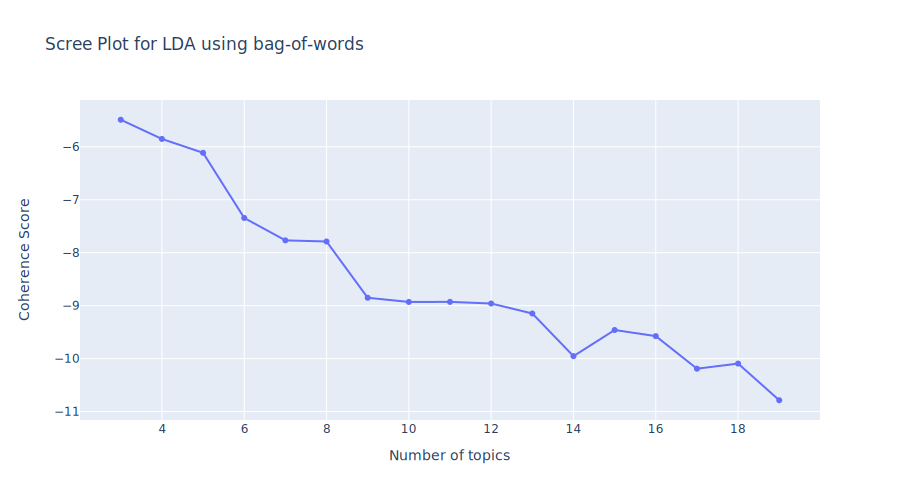

In [10]:
# Plot the reuslts
fig = px.line(model_results, x="Number of topics", y="Coherence Score", title='Scree Plot for LDA using bag-of-words', markers=True)
fig.show()

In [11]:
print(f"From the above graph, it can be observed that the best coherence score of {best_coherence} is obtained using {best_k} topics is closest to 0. Hence, for this data set the optimum number of topics is {best_k}.")

From the above graph, it can be observed that the best coherence score of -5.488990997220976 is obtained using 3 topics is closest to 0. Hence, for this data set the optimum number of topics is 3.


In [12]:
# Create final models with optimum k i.e. 5 for further analysis
lda_model = gensim.models.LdaMulticore(corpus=bow_corpus,
                                            id2word=id2word,
                                            num_topics=best_k,
                                            random_state=42,
                                            chunksize=500,
                                            passes=10,
                                            alpha='asymmetric',
                                            eta='auto',
                                            per_word_topics=True)
    
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, 
                                                corpus=bow_corpus, 
                                                dictionary=id2word, 
                                                coherence='u_mass')

coherence_score = coherence_model_lda.get_coherence()
print(f"The coherence for the {best_k} number of topics is: {coherence_score}")

The coherence for the 3 number of topics is: -5.522843429085495


In [13]:
# Plot the distribution of words in each topic
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, id2word)
pyLDAvis.display(LDAvis_prepared)

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pushkar/miniforge3/en

There is high intertopic distances between topics, though topic 3 and topic 4 have some overlap between them. But the overall result of the model is satisfactory.

In [14]:
# Get the dominant topic number for each 
def dominant_topics(ldamodel, corpus, tweets, texts):
    sent_topics_df = pd.DataFrame()
    for row in tqdm(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True
                )
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add tweets column
    contents = pd.Series(tweets)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.rename(columns={0: "Tweet"}, inplace=True)

    # Add trigrams column
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.rename(columns={0: "Texts"}, inplace=True)
    return sent_topics_df.copy()

topics_df = dominant_topics(ldamodel=lda_model, 
                            corpus=bow_corpus, 
                            tweets=df['tweet'].values.tolist(), 
                            texts=df['trigram'].values.tolist())

100%|██████████| 2770/2770 [00:06<00:00, 458.83it/s]


The dominant topic for each of the tweet is determined and the sample result is as follows:

In [15]:
topics_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Tweet,Texts
0,0,0.9547,"like, drink, order, day, good, work, people, k...",So now you up 3am for work. These boomers 🤬 th...,"[work, boomer, wake, early, bullshxt, stop, bu..."
1,0,0.8630,"like, drink, order, day, good, work, people, k...",@ScottPalmer61 Yes. It’s a special Starbucks a...,"[yes, special, attachment]"
2,0,0.8656,"like, drink, order, day, good, work, people, k...",I like the caramel frappe from Starbucks https...,"[like, caramel, frappe]"
3,0,0.9018,"like, drink, order, day, good, work, people, k...",Why is No Time To Die playing on repeat at #St...,"[time, die, playing, repeat, notice]"
4,0,0.9311,"like, drink, order, day, good, work, people, k...",https://t.co/tgR9Z5p8Ts | Criminals steal 200 ...,"[criminal, steal, customer, datum, singapore, ..."


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

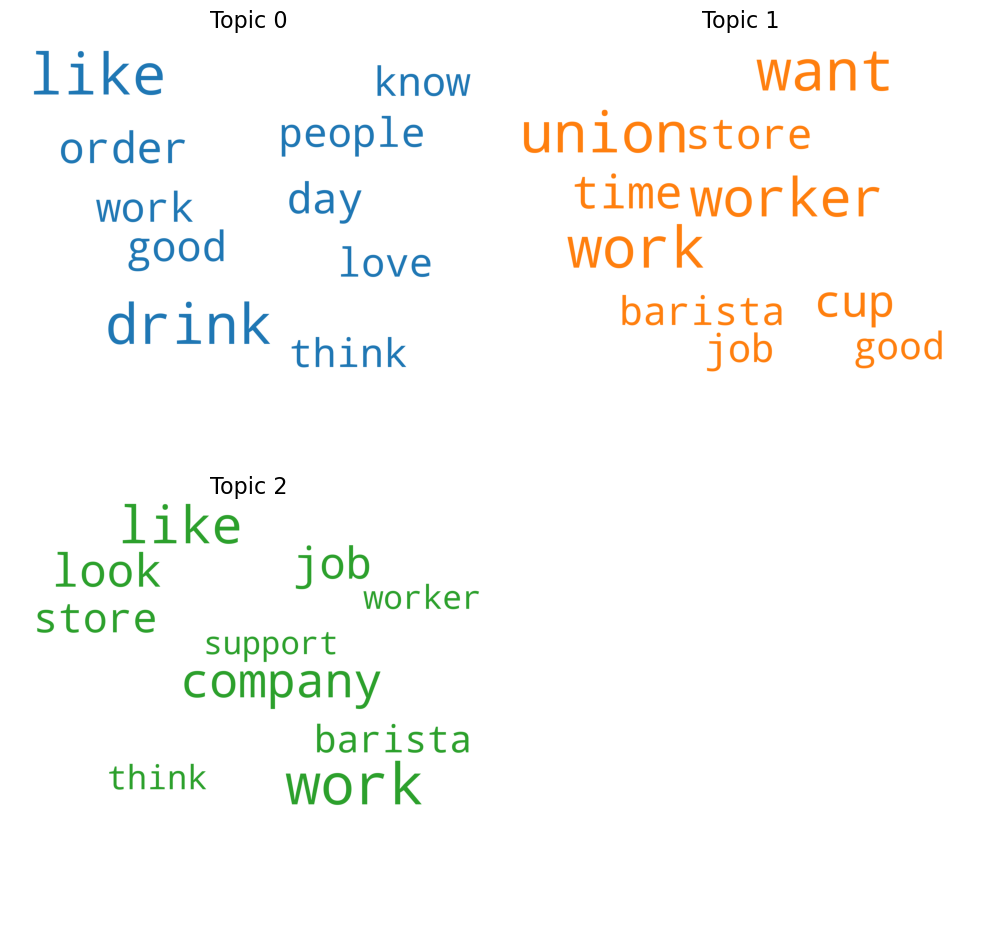

In [16]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    try:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    except:
        pass


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

The above graph shows the word cloud of the dominant words in each topic. The topics can be attributed as follows:
1. The first topic is related to general like of coffee
2. The second topic is related to the company workers
3. The third topic is related to the brand appreciation

/var/folders/zl/bqtzmz3s0xl5_ddgbjsqxsww0000gn/T/ipykernel_5555/3296003400.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/zl/bqtzmz3s0xl5_ddgbjsqxsww0000gn/T/ipykernel_5555/3296003400.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/zl/bqtzmz3s0xl5_ddgbjsqxsww0000gn/T/ipykernel_5555/3296003400.py:24: UserWarning:

FixedFormatter should only be used together with FixedLocator



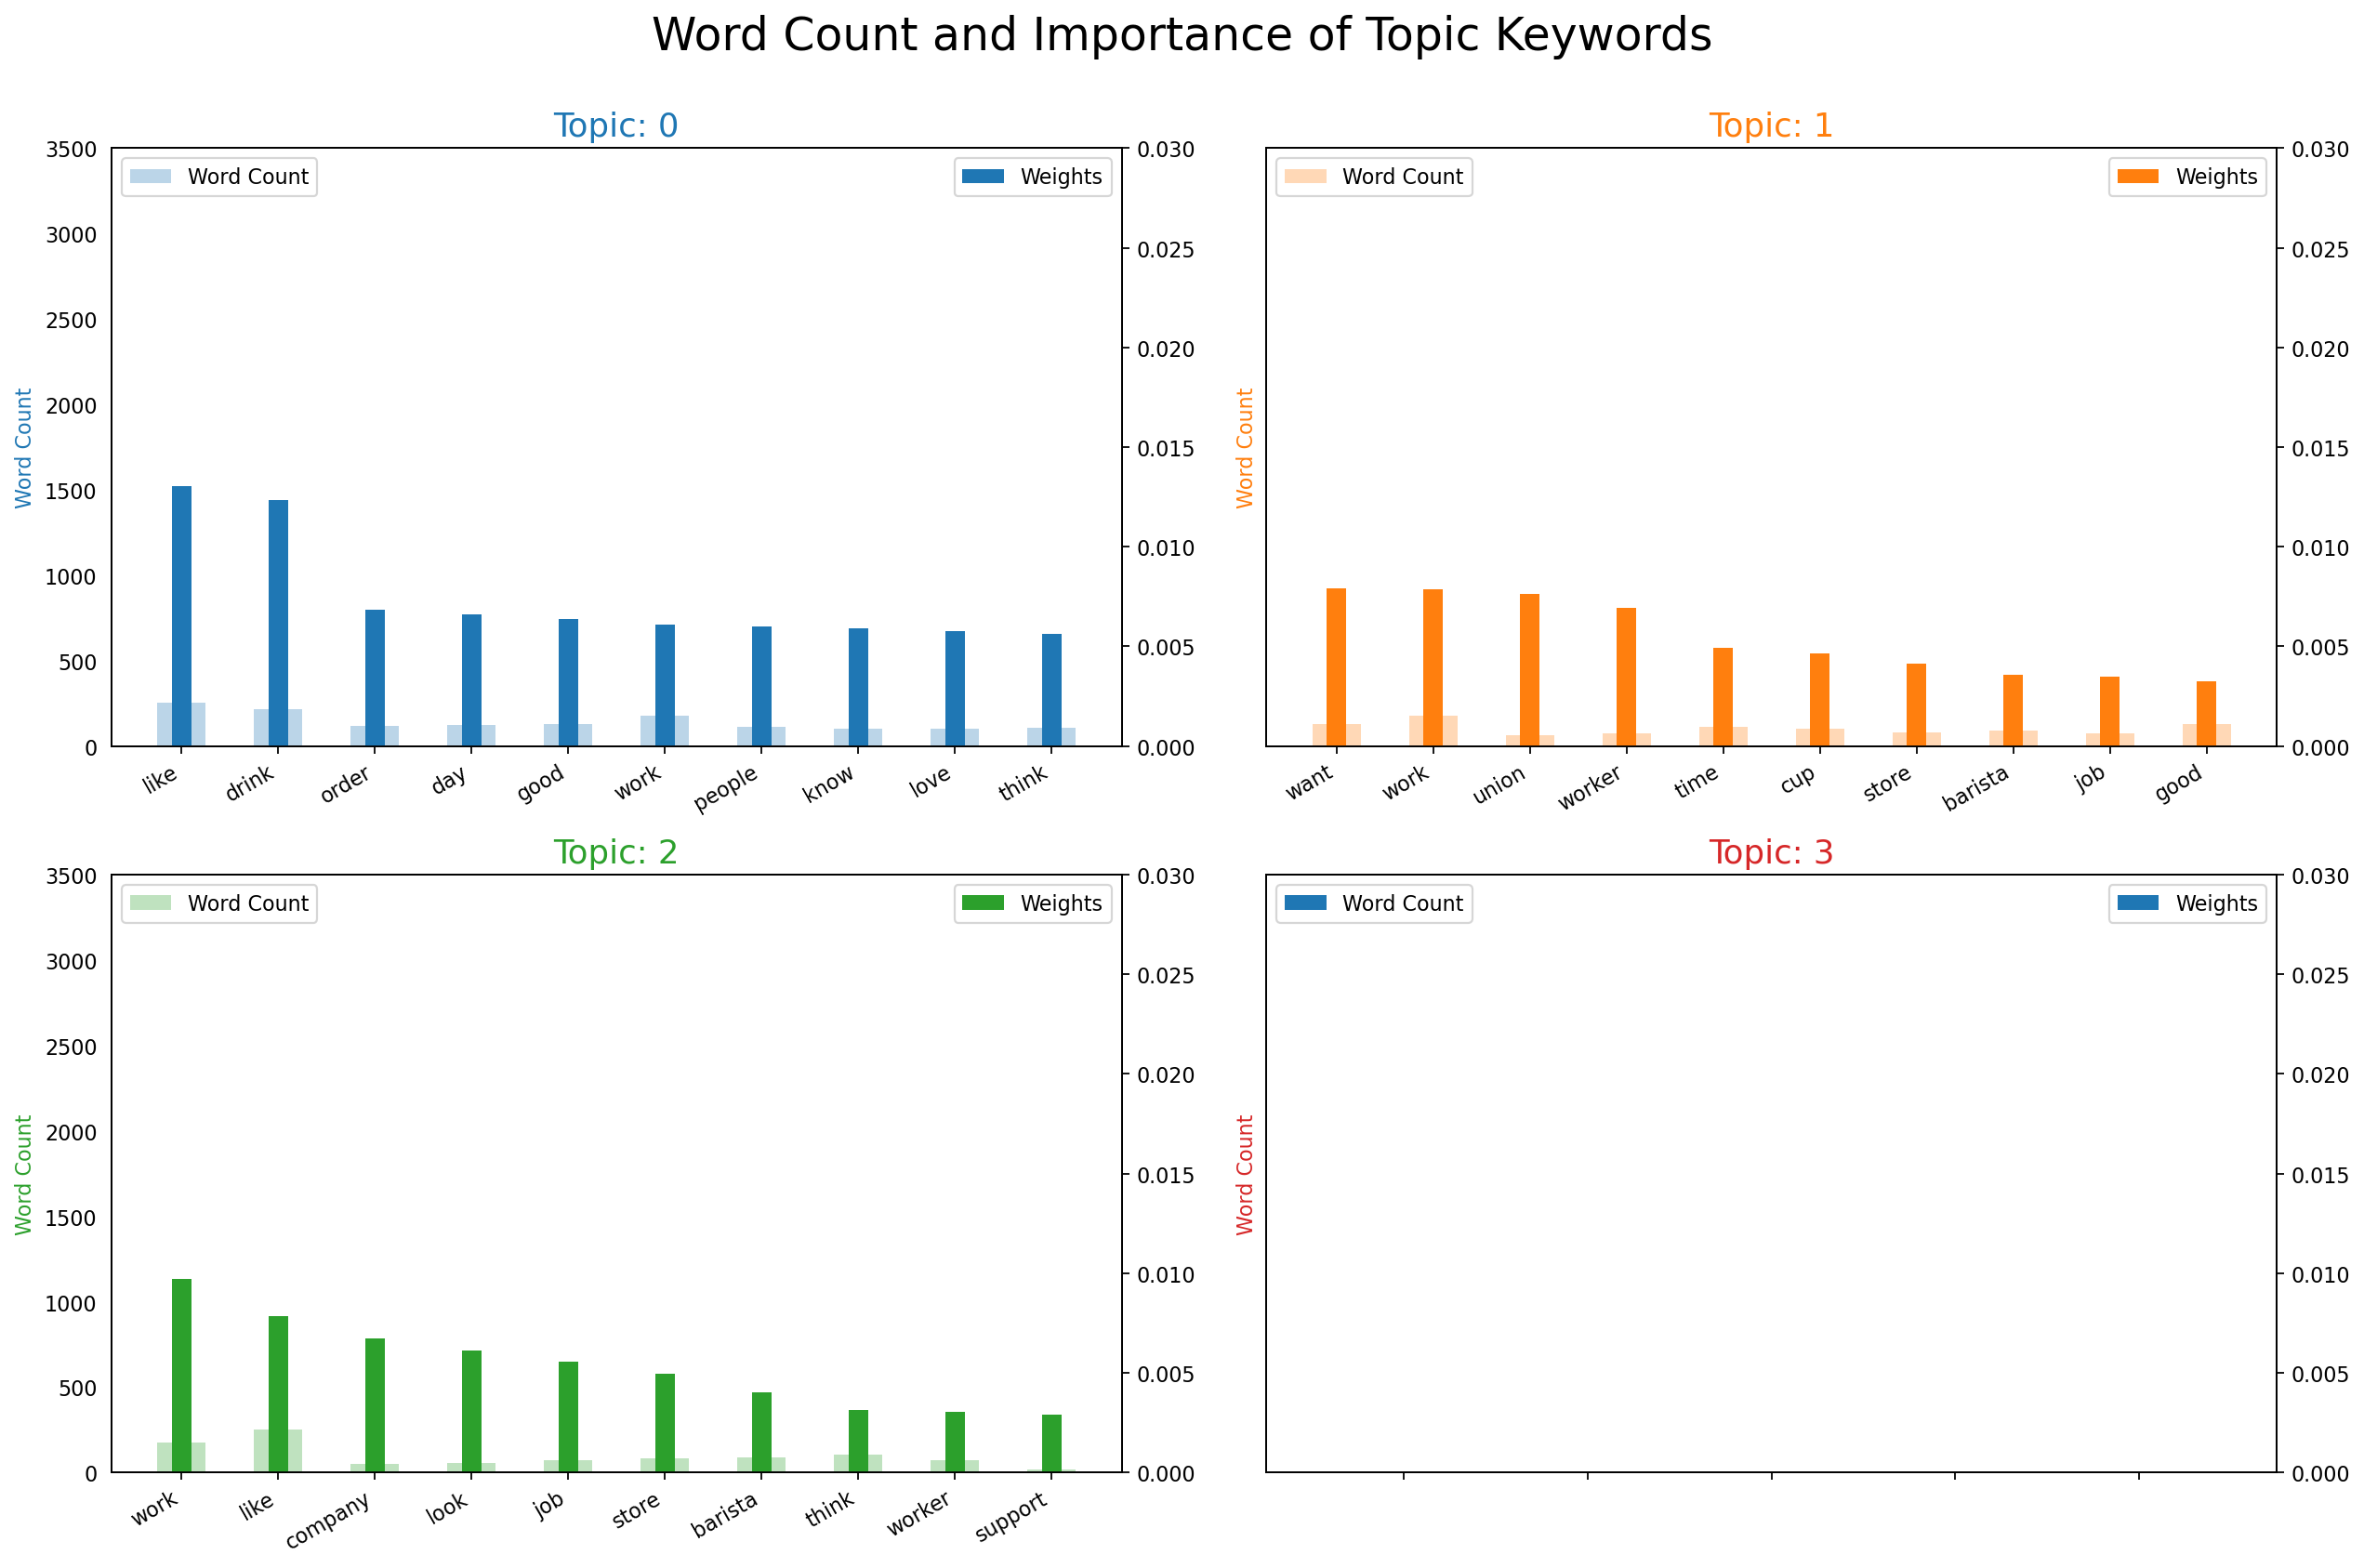

In [17]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in df['trigram'].values.tolist() for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

The above graph is related to the frequency of the words and their corresponding weights in the topics. It can be observed that all words in all the topics have relatively low weightages eventhough certain words have high frequency. But one of the most intriguing result is that no topic is dominated by any single word and the dominant words contribute equally in the model.

## LDA with TF-IDF

The other way to convert text into numbers is term frequency - inverse document frequency (tf-idf) model.

TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval and text mining.

The term frequency (TF) of a word is the number of times the word appears in a document, normalized by the total number of words in the document. The inverse document frequency (IDF) of a word is the logarithmically scaled inverse fraction of the documents that contain the word. The product of these two quantities is the TD-IDF weight of a word in a document.

TD-IDF is typically used to weight the importance of words in a document, in relation to a corpus of documents as a whole. It is often used as a weighting factor in information retrieval and text mining, as it can help to identify the most relevant words in a document. For example, if a certain word appears frequently in a document but not in many other documents, it may be more important to the meaning of the document than a word that appears frequently in many documents.

Before creating the LDA model, it is necessary to create the corpus using tf-idf.

In [18]:
df = main_df.copy()

In [19]:
# Create tf-idf corpus
tfidf = gensim.models.TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus]

The rest of the procedure remains the same for creating the LDA model remains the same.

In [20]:
## Find the appropriate number of topics

# Declare the range for the number of topics to be searched for
topics_range = range(3, 20, 1)

# Initialize a blank variable object for storing the results
model_results = {
    'Number of topics': [],
    'Coherence Score': []
}

# Interate over the range
for k in tqdm(topics_range):

    # Build the LDA model
    lda_model = gensim.models.LdaMulticore(corpus=tfidf_corpus,
                                            id2word=id2word,
                                            num_topics=k,
                                            random_state=14,
                                            chunksize=400,
                                            passes=10,
                                            alpha='asymmetric',
                                            eta='auto',
                                            per_word_topics=True)
    
    # Build the coherence model from the LDA model
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, 
                                                    corpus=tfidf_corpus, 
                                                    dictionary=id2word,
                                                    coherence='u_mass')
    # Get the coherence score
    coherence_score = coherence_model_lda.get_coherence()

    # Append the values to the results object
    model_results['Number of topics'].append(k)
    model_results['Coherence Score'].append(coherence_score)


100%|██████████| 17/17 [02:12<00:00,  7.80s/it]


In [21]:
# Convert the result dictionary to dataframe
model_results = pd.DataFrame(model_results)

# Get the best k and the corresponding coherence score
best_coherence = model_results['Coherence Score'].max()
best_k_index = model_results[model_results['Coherence Score'] == best_coherence].index
best_k = model_results.iloc[best_k_index]["Number of topics"].values[0]

model_results

,Number of topics,Coherence Score
0,3,-8.882971
1,4,-10.162568
2,5,-10.622884
3,6,-12.507163
4,7,-10.490004
5,8,-12.156693
6,9,-12.924883
7,10,-13.261529
8,11,-13.747339
9,12,-15.384174


/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



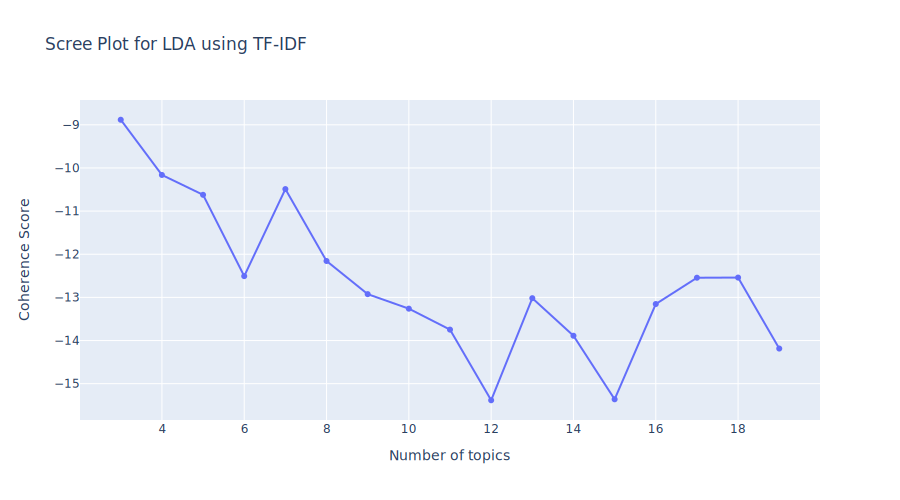

In [22]:
# Plot the reuslts
fig = px.line(model_results, x="Number of topics", y="Coherence Score", title='Scree Plot for LDA using TF-IDF', markers=True)
fig.show()

In [23]:
print(f"From the above graph, it can be observed that the best coherence score of {best_coherence} is obtained using {best_k} topics is closest to 0. Hence, for this data set the optimum number of topics is {best_k}.")

From the above graph, it can be observed that the best coherence score of -8.882970855071166 is obtained using 3 topics is closest to 0. Hence, for this data set the optimum number of topics is 3.


In [24]:
# Create final models with optimum k i.e. 5 for further analysis
lda_model = gensim.models.LdaMulticore(corpus=tfidf_corpus,
                                            id2word=id2word,
                                            num_topics=best_k,
                                            random_state=14,
                                            chunksize=400,
                                            passes=10,
                                            alpha='asymmetric',
                                            eta='auto',
                                            per_word_topics=True)
    
coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, 
                                                corpus=tfidf_corpus, 
                                                dictionary=id2word, 
                                                coherence='u_mass')

coherence_score = coherence_model_lda.get_coherence()
print(f"The coherence for {best_k} number of topics is: {coherence_score}")

The coherence for 3 number of topics is: -8.882970855071166


In [25]:
# Plot the distribution of words in each topic
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, tfidf_corpus, id2word)
pyLDAvis.display(LDAvis_prepared)

LDA with TF-IDF is not giving good results. The intertopic distance for 2 topics is approximately 0.

In [26]:
# Get the dominant topic number for each 
def dominant_topics(ldamodel, corpus, tweets, texts):
    sent_topics_df = pd.DataFrame()
    for row in tqdm(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(
                    pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True
                )
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add tweets column
    contents = pd.Series(tweets)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.rename(columns={0: "Tweet"}, inplace=True)

    # Add trigrams column
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    sent_topics_df.rename(columns={0: "Texts"}, inplace=True)
    return sent_topics_df.copy()

topics_df = dominant_topics(ldamodel=lda_model, 
                            corpus=tfidf_corpus, 
                            tweets=df['tweet'].values.tolist(), 
                            texts=df['trigram'].values.tolist())

100%|██████████| 2770/2770 [00:02<00:00, 1007.94it/s]


The dominant topic for each can be given by:

In [27]:
topics_df.head()

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Tweet,Texts
0,0,0.8728,"like, drink, work, want, good, love, order, da...",So now you up 3am for work. These boomers 🤬 th...,"[work, boomer, wake, early, bullshxt, stop, bu..."
1,0,0.8032,"like, drink, work, want, good, love, order, da...",@ScottPalmer61 Yes. It’s a special Starbucks a...,"[yes, special, attachment]"
2,0,0.8027,"like, drink, work, want, good, love, order, da...",I like the caramel frappe from Starbucks https...,"[like, caramel, frappe]"
3,0,0.8331,"like, drink, work, want, good, love, order, da...",Why is No Time To Die playing on repeat at #St...,"[time, die, playing, repeat, notice]"
4,0,0.8521,"like, drink, work, want, good, love, order, da...",https://t.co/tgR9Z5p8Ts | Criminals steal 200 ...,"[criminal, steal, customer, datum, singapore, ..."


The wordcloud for dominant topics is given by:

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning:

textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.

/Users/pushkar/miniforge3/envs/project/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWa

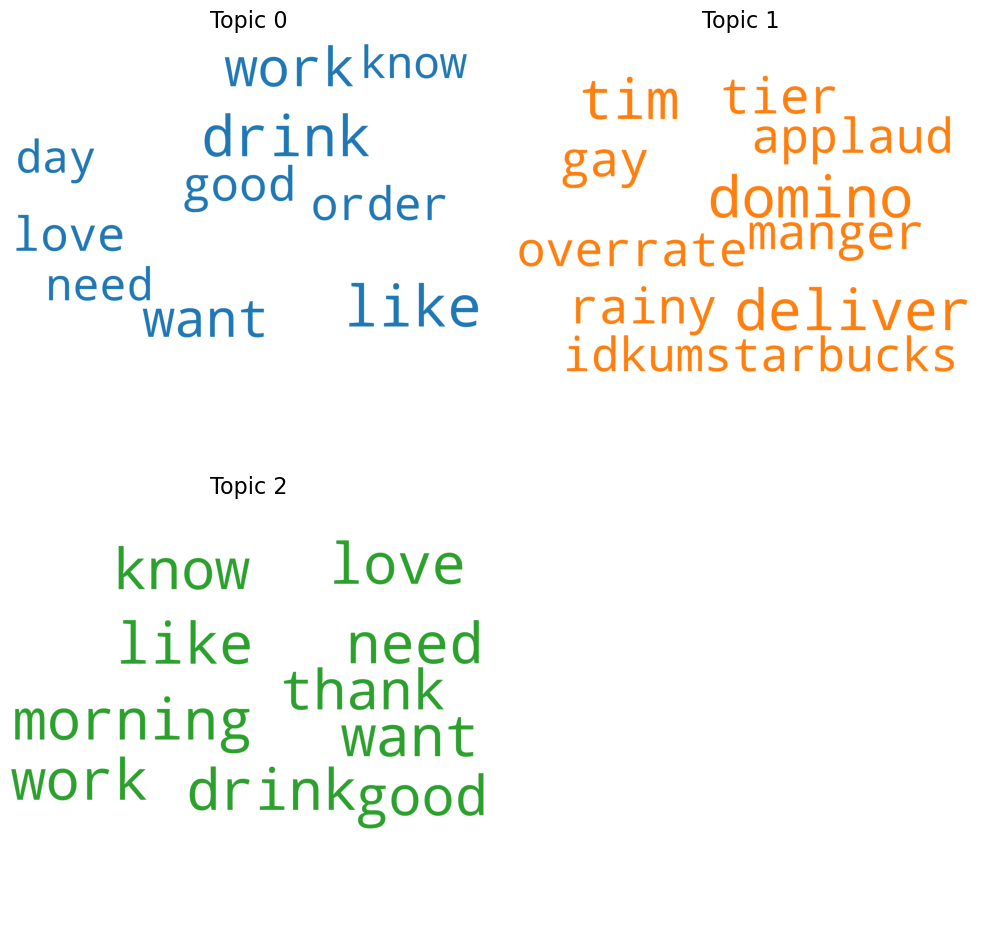

In [28]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    try:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    except:
        pass


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Though there is an overlap between the second and the third topic, but the topics can be distinguished from each other.
1. The first topic is related to general like of coffee
2. The second is related to the company's products
3. The third is related to the feel-good quatient with respect to coffee

/var/folders/zl/bqtzmz3s0xl5_ddgbjsqxsww0000gn/T/ipykernel_5555/2927128625.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/zl/bqtzmz3s0xl5_ddgbjsqxsww0000gn/T/ipykernel_5555/2927128625.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/zl/bqtzmz3s0xl5_ddgbjsqxsww0000gn/T/ipykernel_5555/2927128625.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



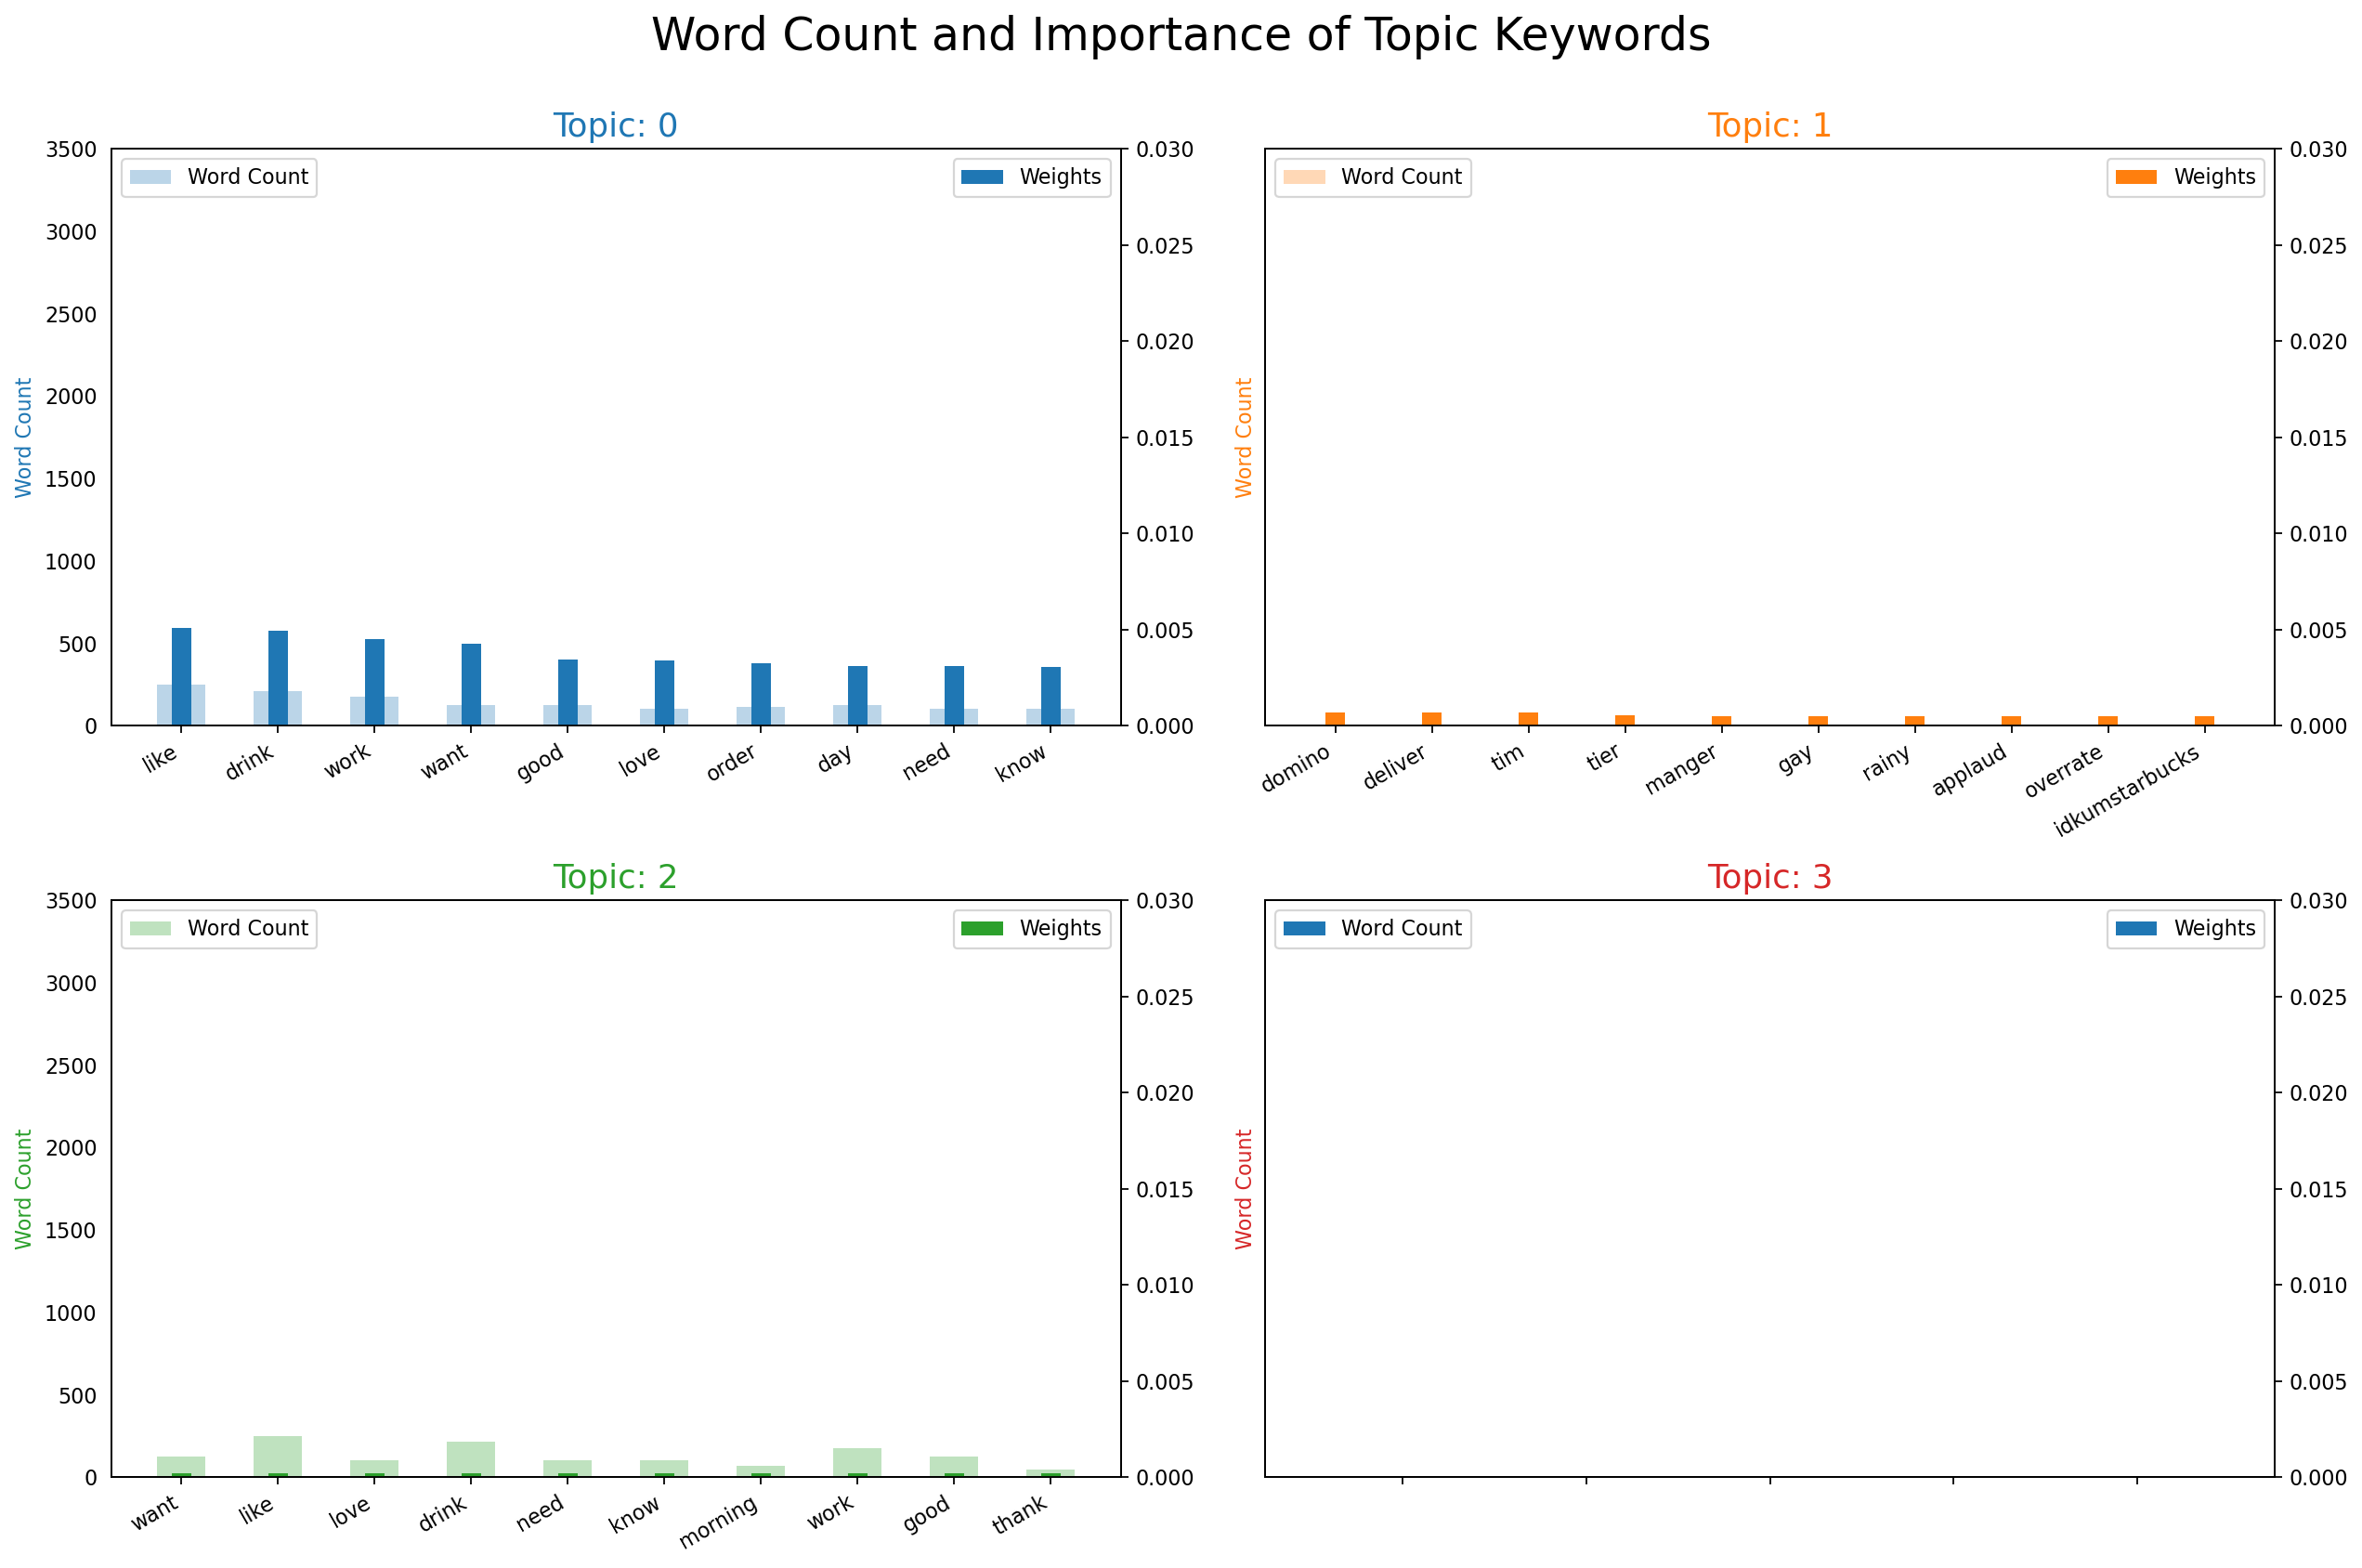

In [29]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in df['trigram'].values.tolist() for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    try:
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    except:
        pass

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

Though the dominant words in the two overlapping topics are different. The frequency for words as compared to weights of words is too high in topic 1, while the situation is other way round for topic 2. No inference can be made from such result.